In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.search_factory import SearchFactory

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

from lib.model.inspector.prediction_inspector_factory import PredictionInspectorFactory

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
dataset_name='8k'
# dataset_name='30k'

embedding_vector_dim = 300
embedding_token_count = 6
embedding_token_count = 840
embeding_name = f'{embedding_token_count}B.{embedding_vector_dim}d'
word_embedding_path = f'./dataset/glove.{embeding_name}.txt'



dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.16, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.22, shuffle=True)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6796, Val: 1010, Test: 285


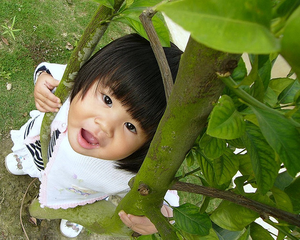

,Description
0,girl in white and pink sweater be look up through tree branch
1,little girl with black hair poke her head through tree branch
2,an asian little girl hug two tree branch
3,young asian girl stand between two tree trunk
4,small girl wear white sweater stand between branch of tree with green leaf


In [6]:
show_sample(train_samples[0])

In [7]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [8]:
min_occurs=10

vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [9]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [10]:
len(word_to_index)

1593

In [11]:
dataset.max_desc_len()

174

In [12]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)

embedding_matrix = load_obj(descrption_embedding_path)
len(embedding_matrix)

1593

In [13]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [14]:
# 1ª Train:
epochs=10
lr=0.001
batch_size = 12

# 2ª Train:
#epochs=10
#lr=0.0001
#batch_size = 20

steps_per_epoch=len(train_samples)/batch_size

In [15]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [16]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=100, 
        evaluate_interval=100, 
        batch_size=batch_size
    )
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Metrics: ['loss', 'rmse']
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Feature (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
Description_Sequence (InputLaye (None, 174)          0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           Image_Feature[0][0]              
____________________________________________________________________________________________

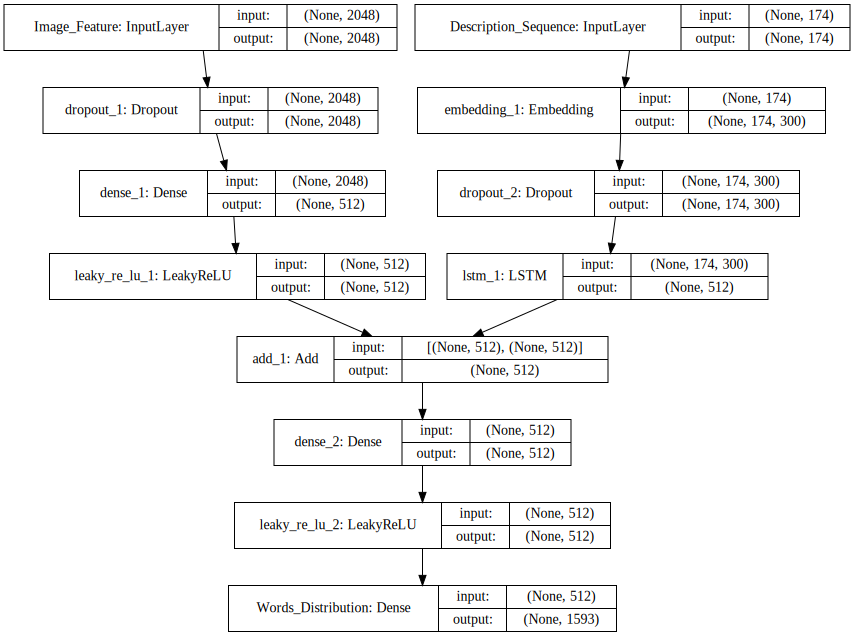

In [17]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
model.show()    

In [18]:
model.load(f'{weights_path}/weights__epoch_01__loss_2.3339__acc_0.0210.h5')

# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Load weights from weights/8k/weights__epoch_01__loss_2.3339__acc_0.0210.h5


In [19]:
import pandas as pd
import datetime

def random_sample(): return test_samples[random.randint(0, len(test_samples)-1)]

def create_inspector(k, verbose=False):
    return PredictionInspectorFactory.create(
            search=SearchFactory.beam_search(
                model=model,
                word_to_index=word_to_index,
                index_to_word=index_to_word,
                max_seq_len=dataset.max_desc_len(),
                k=k,
                verbose=verbose
            ),
            image_features=image_features,
            descriptions=dataset.descriptions()
        )

def find_best_k(k_values, times = 20):
    metrics = []
    for k in k_values:
        inspector = create_inspector(k)
        wmd_sim_sum = 0

        for inspection_time in range(times):
            start_time = datetime.datetime.now()
            result = inspector.inspect(random_sample(), show=False)

            wmd_sim_sum += result.wmd_sim()
            inspection_time+=1
            time = datetime.datetime.now() - start_time
            print(f'K: {k}, Inspection: {inspection_time}, WMDSim: {result.wmd_sim()}, Time: {time}')

        mean_wmd_sim =  wmd_sim_sum / times
        print(f'K: {k}, WMDSim: {mean_wmd_sim}')
        metrics.append([k, mean_wmd_sim])
    return metrics

In [147]:
# find_best_k(k_values=range(1, 30), times=20)

K: 1, Inspection: 1, WMDSim: 0.6785960572976532, Time: 0:00:00.633171
K: 1, Inspection: 2, WMDSim: 0.8087121851073178, Time: 0:00:00.432661
K: 1, Inspection: 3, WMDSim: 0.5931919268937398, Time: 0:00:00.633142
K: 1, Inspection: 4, WMDSim: 0.5939350224611436, Time: 0:00:00.404018
K: 1, Inspection: 5, WMDSim: 0.7304103916786608, Time: 0:00:00.295250
K: 1, Inspection: 6, WMDSim: 0.6972125100969556, Time: 0:00:00.897798
K: 1, Inspection: 7, WMDSim: 0.6266050898990059, Time: 0:00:00.348708
K: 1, Inspection: 8, WMDSim: 0.6374186577956756, Time: 0:00:00.366493
K: 1, Inspection: 9, WMDSim: 0.6293878669406026, Time: 0:00:00.414110
K: 1, Inspection: 10, WMDSim: 0.628104138962416, Time: 0:00:00.296400
K: 1, Inspection: 11, WMDSim: 0.785732659493455, Time: 0:00:00.295583
K: 1, Inspection: 12, WMDSim: 0.6450858190901204, Time: 0:00:00.355415
K: 1, Inspection: 13, WMDSim: 0.6273907139490847, Time: 0:00:00.356193
K: 1, Inspection: 14, WMDSim: 0.5808094439319101, Time: 0:00:00.690821
K: 1, Inspection:

K: 2, Inspection: 1, WMDSim: 0.5755434657544221, Time: 0:00:01.366948
K: 2, Inspection: 2, WMDSim: 0.5836441249451276, Time: 0:00:00.755871
K: 2, Inspection: 3, WMDSim: 0.6115961092249242, Time: 0:00:00.955346
K: 2, Inspection: 4, WMDSim: 0.6785153343906839, Time: 0:00:00.668158
K: 2, Inspection: 5, WMDSim: 0.7170245991292008, Time: 0:00:00.665432
K: 2, Inspection: 6, WMDSim: 0.6022830566514306, Time: 0:00:00.921931
K: 2, Inspection: 7, WMDSim: 0.6346326360847839, Time: 0:00:00.628332
K: 2, Inspection: 8, WMDSim: 0.6481870184526957, Time: 0:00:01.169173
K: 2, Inspection: 9, WMDSim: 0.5562895422126173, Time: 0:00:00.701735
K: 2, Inspection: 10, WMDSim: 0.5081396843459639, Time: 0:00:00.727562
K: 2, Inspection: 11, WMDSim: 0.6785153343906839, Time: 0:00:00.685156
K: 2, Inspection: 12, WMDSim: 0.5658244604783003, Time: 0:00:01.516744
K: 2, Inspection: 13, WMDSim: 0.6826461046166811, Time: 0:00:00.678440
K: 2, Inspection: 14, WMDSim: 0.6450858190901204, Time: 0:00:00.666330
K: 2, Inspectio

K: 3, Inspection: 1, WMDSim: 0.5857117102673194, Time: 0:00:02.267937
K: 3, Inspection: 2, WMDSim: 0.7469515351211384, Time: 0:00:01.302283
K: 3, Inspection: 3, WMDSim: 0.6010681792947938, Time: 0:00:01.185304
K: 3, Inspection: 4, WMDSim: 0.69798622785237, Time: 0:00:01.072407
K: 3, Inspection: 5, WMDSim: 0.5625725947535786, Time: 0:00:01.060992
K: 3, Inspection: 6, WMDSim: 0.5820720906976493, Time: 0:00:01.120448
K: 3, Inspection: 7, WMDSim: 0.6688715148599094, Time: 0:00:01.165926
K: 3, Inspection: 8, WMDSim: 0.6527961910534834, Time: 0:00:01.556649
K: 3, Inspection: 9, WMDSim: 0.7556873209833309, Time: 0:00:01.352196
K: 3, Inspection: 10, WMDSim: 0.5374816336176204, Time: 0:00:01.775012
K: 3, Inspection: 11, WMDSim: 0.5783355474015289, Time: 0:00:00.845561
K: 3, Inspection: 12, WMDSim: 0.6668778105838882, Time: 0:00:00.898273
K: 3, Inspection: 13, WMDSim: 0.6089206775180138, Time: 0:00:02.270921
K: 3, Inspection: 14, WMDSim: 0.7351614154977748, Time: 0:00:01.496835
K: 3, Inspection:

K: 4, Inspection: 1, WMDSim: 0.5763458417632995, Time: 0:00:02.061684
K: 4, Inspection: 2, WMDSim: 0.644937142332456, Time: 0:00:02.408167
K: 4, Inspection: 3, WMDSim: 0.6378254149445587, Time: 0:00:01.974033
K: 4, Inspection: 4, WMDSim: 0.628017558834915, Time: 0:00:01.566946
K: 4, Inspection: 5, WMDSim: 0.6113359708148227, Time: 0:00:02.369256
K: 4, Inspection: 6, WMDSim: 0.6754153628728445, Time: 0:00:01.245612
K: 4, Inspection: 7, WMDSim: 0.6397792872261532, Time: 0:00:02.213952
K: 4, Inspection: 8, WMDSim: 0.5862459192152458, Time: 0:00:02.122344
K: 4, Inspection: 9, WMDSim: 0.7213011831988936, Time: 0:00:01.555072
K: 4, Inspection: 10, WMDSim: 0.6450858190901204, Time: 0:00:01.219679
K: 4, Inspection: 11, WMDSim: 0.63135865518539, Time: 0:00:02.208423
K: 4, Inspection: 12, WMDSim: 0.6155096732075815, Time: 0:00:01.542040
K: 4, Inspection: 13, WMDSim: 0.6907725999936766, Time: 0:00:01.450956
K: 4, Inspection: 14, WMDSim: 0.7080319304094831, Time: 0:00:01.625942
K: 4, Inspection: 1

K: 5, Inspection: 1, WMDSim: 0.6794172923699073, Time: 0:00:03.147878
K: 5, Inspection: 2, WMDSim: 0.6518133929395791, Time: 0:00:02.612639
K: 5, Inspection: 3, WMDSim: 0.6445453057567538, Time: 0:00:02.366708
K: 5, Inspection: 4, WMDSim: 0.7795841053364958, Time: 0:00:01.799844
K: 5, Inspection: 5, WMDSim: 0.6821444680891421, Time: 0:00:01.549485
K: 5, Inspection: 6, WMDSim: 0.6437313228056858, Time: 0:00:02.474719
K: 5, Inspection: 7, WMDSim: 0.621955072531898, Time: 0:00:01.882428
K: 5, Inspection: 8, WMDSim: 0.5804356186644475, Time: 0:00:02.934771
K: 5, Inspection: 9, WMDSim: 0.5467405118829837, Time: 0:00:02.559063
K: 5, Inspection: 10, WMDSim: 0.7401248931638473, Time: 0:00:01.908998
K: 5, Inspection: 11, WMDSim: 0.5751661173054403, Time: 0:00:01.912734
K: 5, Inspection: 12, WMDSim: 0.5913448217847284, Time: 0:00:02.537079
K: 5, Inspection: 13, WMDSim: 0.6259209987787604, Time: 0:00:01.820551
K: 5, Inspection: 14, WMDSim: 0.5735567292659727, Time: 0:00:01.548361
K: 5, Inspection

K: 6, Inspection: 1, WMDSim: 0.6058210298614553, Time: 0:00:02.773936
K: 6, Inspection: 2, WMDSim: 0.616240720151261, Time: 0:00:03.179946
K: 6, Inspection: 3, WMDSim: 0.660104765056647, Time: 0:00:02.045751
K: 6, Inspection: 4, WMDSim: 0.5258107875755077, Time: 0:00:02.618389
K: 6, Inspection: 5, WMDSim: 0.6476491430386159, Time: 0:00:03.228058
K: 6, Inspection: 6, WMDSim: 0.5864879250732616, Time: 0:00:02.213818
K: 6, Inspection: 7, WMDSim: 0.6313471398342317, Time: 0:00:02.248831
K: 6, Inspection: 8, WMDSim: 0.6139185155493627, Time: 0:00:03.561664
K: 6, Inspection: 9, WMDSim: 0.5239601287230641, Time: 0:00:02.639081
K: 6, Inspection: 10, WMDSim: 0.6465922590201512, Time: 0:00:03.028760
K: 6, Inspection: 11, WMDSim: 0.6821444680891421, Time: 0:00:01.823605
K: 6, Inspection: 12, WMDSim: 0.64915432298616, Time: 0:00:02.030938
K: 6, Inspection: 13, WMDSim: 0.6081057502990104, Time: 0:00:03.241509
K: 6, Inspection: 14, WMDSim: 0.5967101977482578, Time: 0:00:02.755204
K: 6, Inspection: 1

K: 7, Inspection: 1, WMDSim: 0.6638248087148584, Time: 0:00:03.618913
K: 7, Inspection: 2, WMDSim: 0.6020561358546604, Time: 0:00:03.432546
K: 7, Inspection: 3, WMDSim: 0.7257837130378902, Time: 0:00:02.481662
K: 7, Inspection: 4, WMDSim: 0.6113359708148227, Time: 0:00:03.936566
K: 7, Inspection: 5, WMDSim: 0.6619155937145118, Time: 0:00:02.211529
K: 7, Inspection: 6, WMDSim: 0.6632416524048798, Time: 0:00:04.742027
K: 7, Inspection: 7, WMDSim: 0.576215895794226, Time: 0:00:02.343462
K: 7, Inspection: 8, WMDSim: 0.7257837130378902, Time: 0:00:02.451403
K: 7, Inspection: 9, WMDSim: 0.7361210433592887, Time: 0:00:02.749666
K: 7, Inspection: 10, WMDSim: 0.6517442181912169, Time: 0:00:02.133036
K: 7, Inspection: 11, WMDSim: 0.7162028081421895, Time: 0:00:02.163220
K: 7, Inspection: 12, WMDSim: 0.7167897872363916, Time: 0:00:02.373435
K: 7, Inspection: 13, WMDSim: 0.5301571701089757, Time: 0:00:03.342002
K: 7, Inspection: 14, WMDSim: 0.6821444680891421, Time: 0:00:02.024664
K: 7, Inspection

K: 8, Inspection: 1, WMDSim: 0.6836727292632748, Time: 0:00:04.259299
K: 8, Inspection: 2, WMDSim: 0.5671046450291438, Time: 0:00:02.974214
K: 8, Inspection: 3, WMDSim: 0.6267906933431538, Time: 0:00:03.221762
K: 8, Inspection: 4, WMDSim: 0.5005586590476957, Time: 0:00:04.307290
K: 8, Inspection: 5, WMDSim: 0.5959657513970177, Time: 0:00:03.029520
K: 8, Inspection: 6, WMDSim: 0.6502284548879126, Time: 0:00:03.634860
K: 8, Inspection: 7, WMDSim: 0.4975424317590421, Time: 0:00:03.805321
K: 8, Inspection: 8, WMDSim: 0.601945130649985, Time: 0:00:02.984004
K: 8, Inspection: 9, WMDSim: 0.689225832341972, Time: 0:00:02.504553
K: 8, Inspection: 10, WMDSim: 0.5838804111557153, Time: 0:00:04.298615
K: 8, Inspection: 11, WMDSim: 0.7225476428848114, Time: 0:00:03.054495
K: 8, Inspection: 12, WMDSim: 0.5857766018079545, Time: 0:00:04.113443
K: 8, Inspection: 13, WMDSim: 0.6965752625897002, Time: 0:00:03.260125
K: 8, Inspection: 14, WMDSim: 0.6457932444820449, Time: 0:00:03.415329
K: 8, Inspection:

K: 9, Inspection: 1, WMDSim: 0.7469515393656521, Time: 0:00:02.784690
K: 9, Inspection: 2, WMDSim: 0.6161225712664893, Time: 0:00:03.506462
K: 9, Inspection: 3, WMDSim: 0.5760566726662562, Time: 0:00:03.300740
K: 9, Inspection: 4, WMDSim: 0.6127843274940762, Time: 0:00:03.098446
K: 9, Inspection: 5, WMDSim: 0.6965752625897002, Time: 0:00:03.521037
K: 9, Inspection: 6, WMDSim: 0.5800793484124434, Time: 0:00:05.850711
K: 9, Inspection: 7, WMDSim: 0.7795841053364958, Time: 0:00:03.008909
K: 9, Inspection: 8, WMDSim: 0.5511126021701733, Time: 0:00:02.648981
K: 9, Inspection: 9, WMDSim: 0.7419503017912832, Time: 0:00:02.820066
K: 9, Inspection: 10, WMDSim: 0.4975424317590421, Time: 0:00:04.350897
K: 9, Inspection: 11, WMDSim: 0.5617818326604509, Time: 0:00:03.847952
K: 9, Inspection: 12, WMDSim: 0.5301571701089757, Time: 0:00:04.066689
K: 9, Inspection: 13, WMDSim: 0.6785760316508662, Time: 0:00:02.894347
K: 9, Inspection: 14, WMDSim: 0.565780849730454, Time: 0:00:02.969978
K: 9, Inspection

K: 10, Inspection: 1, WMDSim: 0.5640702513020726, Time: 0:00:04.727969
K: 10, Inspection: 2, WMDSim: 0.6908525035411293, Time: 0:00:03.266755
K: 10, Inspection: 3, WMDSim: 0.5639168861616445, Time: 0:00:03.667399
K: 10, Inspection: 4, WMDSim: 0.5154571081703626, Time: 0:00:03.520372
K: 10, Inspection: 5, WMDSim: 0.6762057680534135, Time: 0:00:04.974115
K: 10, Inspection: 6, WMDSim: 0.6476491430386159, Time: 0:00:05.073945
K: 10, Inspection: 7, WMDSim: 0.5913821448418355, Time: 0:00:05.052712
K: 10, Inspection: 8, WMDSim: 0.619742964295589, Time: 0:00:04.542013
K: 10, Inspection: 9, WMDSim: 0.5683233048298793, Time: 0:00:03.272379
K: 10, Inspection: 10, WMDSim: 0.6093546116808508, Time: 0:00:03.270330
K: 10, Inspection: 11, WMDSim: 0.6494488698998256, Time: 0:00:04.767504
K: 10, Inspection: 12, WMDSim: 0.6906546979131277, Time: 0:00:03.223484
K: 10, Inspection: 13, WMDSim: 0.6855936066848305, Time: 0:00:03.515867
K: 10, Inspection: 14, WMDSim: 0.603484398789068, Time: 0:00:04.501918
K: 

K: 11, Inspection: 1, WMDSim: 0.6102656138666225, Time: 0:00:04.346464
K: 11, Inspection: 2, WMDSim: 0.636425508452916, Time: 0:00:02.840113
K: 11, Inspection: 3, WMDSim: 0.6297135697192858, Time: 0:00:05.250965
K: 11, Inspection: 4, WMDSim: 0.5952860636958, Time: 0:00:05.325698
K: 11, Inspection: 5, WMDSim: 0.696058429619719, Time: 0:00:03.228468
K: 11, Inspection: 6, WMDSim: 0.6093546116808508, Time: 0:00:03.472007
K: 11, Inspection: 7, WMDSim: 0.5747553197155578, Time: 0:00:05.789199
K: 11, Inspection: 8, WMDSim: 0.6667752983108566, Time: 0:00:03.622414
K: 11, Inspection: 9, WMDSim: 0.6196021863053758, Time: 0:00:04.236188
K: 11, Inspection: 10, WMDSim: 0.6219594843251167, Time: 0:00:06.479812
K: 11, Inspection: 11, WMDSim: 0.6071690523456844, Time: 0:00:06.357212
K: 11, Inspection: 12, WMDSim: 0.559302067371447, Time: 0:00:03.701800
K: 11, Inspection: 13, WMDSim: 0.6295306383217987, Time: 0:00:04.656413
K: 11, Inspection: 14, WMDSim: 0.603484398789068, Time: 0:00:04.985084
K: 11, I

K: 12, Inspection: 1, WMDSim: 0.629249210358928, Time: 0:00:05.786954
K: 12, Inspection: 2, WMDSim: 0.8089889991471816, Time: 0:00:04.015409
K: 12, Inspection: 3, WMDSim: 0.6933438979755226, Time: 0:00:04.033894
K: 12, Inspection: 4, WMDSim: 0.6667752983108566, Time: 0:00:03.845673
K: 12, Inspection: 5, WMDSim: 0.7213011831988936, Time: 0:00:03.870879
K: 12, Inspection: 6, WMDSim: 0.6047760699107737, Time: 0:00:06.928522
K: 12, Inspection: 7, WMDSim: 0.6491541966255924, Time: 0:00:05.459717
K: 12, Inspection: 8, WMDSim: 0.5963957488212333, Time: 0:00:04.524509
K: 12, Inspection: 9, WMDSim: 0.7165898942694636, Time: 0:00:03.460368
K: 12, Inspection: 10, WMDSim: 0.5936152369303398, Time: 0:00:04.481791
K: 12, Inspection: 11, WMDSim: 0.5917734975471688, Time: 0:00:04.902741
K: 12, Inspection: 12, WMDSim: 0.5478179679062811, Time: 0:00:05.666947
K: 12, Inspection: 13, WMDSim: 0.5668952667810332, Time: 0:00:03.816980
K: 12, Inspection: 14, WMDSim: 0.628817165533982, Time: 0:00:06.736053
K: 

K: 13, Inspection: 1, WMDSim: 0.5395955264269853, Time: 0:00:05.868483
K: 13, Inspection: 2, WMDSim: 0.6220332498720904, Time: 0:00:07.134756
K: 13, Inspection: 3, WMDSim: 0.5411283385824422, Time: 0:00:06.043399
K: 13, Inspection: 4, WMDSim: 0.633595907221917, Time: 0:00:04.084548
K: 13, Inspection: 5, WMDSim: 0.592073175192979, Time: 0:00:06.113035
K: 13, Inspection: 6, WMDSim: 0.5855678797953167, Time: 0:00:07.826396
K: 13, Inspection: 7, WMDSim: 0.7171181958879379, Time: 0:00:03.888060
K: 13, Inspection: 8, WMDSim: 0.7171181958879379, Time: 0:00:03.878768
K: 13, Inspection: 9, WMDSim: 0.6347361583052351, Time: 0:00:04.531558
K: 13, Inspection: 10, WMDSim: 0.7227053438053416, Time: 0:00:04.830110
K: 13, Inspection: 11, WMDSim: 0.6230052316569833, Time: 0:00:04.999517
K: 13, Inspection: 12, WMDSim: 0.8284437112169479, Time: 0:00:03.519343
K: 13, Inspection: 13, WMDSim: 0.5330211284468149, Time: 0:00:04.662756
K: 13, Inspection: 14, WMDSim: 0.6483506638285467, Time: 0:00:06.622917
K: 

K: 14, Inspection: 1, WMDSim: 0.541882611306749, Time: 0:00:05.430078
K: 14, Inspection: 2, WMDSim: 0.6232645170310354, Time: 0:00:03.934572
K: 14, Inspection: 3, WMDSim: 0.5879603321366286, Time: 0:00:07.524465
K: 14, Inspection: 4, WMDSim: 0.7193672726260602, Time: 0:00:05.742785
K: 14, Inspection: 5, WMDSim: 0.629249183079471, Time: 0:00:06.722786
K: 14, Inspection: 6, WMDSim: 0.5900439613799631, Time: 0:00:06.662959
K: 14, Inspection: 7, WMDSim: 0.6483506638285467, Time: 0:00:07.316394
K: 14, Inspection: 8, WMDSim: 0.6510846861916542, Time: 0:00:06.391038
K: 14, Inspection: 9, WMDSim: 0.6068110366682624, Time: 0:00:04.604549
K: 14, Inspection: 10, WMDSim: 0.5532556718562808, Time: 0:00:06.706489
K: 14, Inspection: 11, WMDSim: 0.6785268482851691, Time: 0:00:06.609413
K: 14, Inspection: 12, WMDSim: 0.629249183079471, Time: 0:00:06.706447
K: 14, Inspection: 13, WMDSim: 0.7374527426743557, Time: 0:00:04.880358
K: 14, Inspection: 14, WMDSim: 0.5532556718562808, Time: 0:00:06.702805
K: 1

K: 15, Inspection: 1, WMDSim: 0.512069395795048, Time: 0:00:06.651147
K: 15, Inspection: 2, WMDSim: 0.5449630473815403, Time: 0:00:04.768678
K: 15, Inspection: 3, WMDSim: 0.5418825979893557, Time: 0:00:05.819646
K: 15, Inspection: 4, WMDSim: 0.5640717496098651, Time: 0:00:05.774913
K: 15, Inspection: 5, WMDSim: 0.6003551073703142, Time: 0:00:06.924868
K: 15, Inspection: 6, WMDSim: 0.6161932441568162, Time: 0:00:05.021643
K: 15, Inspection: 7, WMDSim: 0.636425508452916, Time: 0:00:03.842794
K: 15, Inspection: 8, WMDSim: 0.5641549543935277, Time: 0:00:07.157428
K: 15, Inspection: 9, WMDSim: 0.5825085010002796, Time: 0:00:08.673191
K: 15, Inspection: 10, WMDSim: 0.5936230852247201, Time: 0:00:07.468087
K: 15, Inspection: 11, WMDSim: 0.6081783444997276, Time: 0:00:05.644547
K: 15, Inspection: 12, WMDSim: 0.6003551073703142, Time: 0:00:07.000765
K: 15, Inspection: 13, WMDSim: 0.6765135448235583, Time: 0:00:07.770815
K: 15, Inspection: 14, WMDSim: 0.5710635237520606, Time: 0:00:09.002229
K: 

K: 16, Inspection: 1, WMDSim: 0.7079008222400351, Time: 0:00:06.176798
K: 16, Inspection: 2, WMDSim: 0.6161932441568162, Time: 0:00:05.336585
K: 16, Inspection: 3, WMDSim: 0.6232645170310354, Time: 0:00:04.563598
K: 16, Inspection: 4, WMDSim: 0.6329248750641836, Time: 0:00:07.920628
K: 16, Inspection: 5, WMDSim: 0.5154342354237866, Time: 0:00:06.626379
K: 16, Inspection: 6, WMDSim: 0.6491541966255924, Time: 0:00:06.782731
K: 16, Inspection: 7, WMDSim: 0.6031033815672442, Time: 0:00:09.800050
K: 16, Inspection: 8, WMDSim: 0.5694146725821595, Time: 0:00:10.866825
K: 16, Inspection: 9, WMDSim: 0.5746490642610916, Time: 0:00:08.216880
K: 16, Inspection: 10, WMDSim: 0.6460021536043427, Time: 0:00:07.390474
K: 16, Inspection: 11, WMDSim: 0.7286309557968973, Time: 0:00:09.729653
K: 16, Inspection: 12, WMDSim: 0.7201374829869759, Time: 0:00:04.957959
K: 16, Inspection: 13, WMDSim: 0.5901027357000158, Time: 0:00:08.071904
K: 16, Inspection: 14, WMDSim: 0.5512968740825361, Time: 0:00:09.355151
K

K: 17, Inspection: 1, WMDSim: 0.7152284846366774, Time: 0:00:06.287646
K: 17, Inspection: 2, WMDSim: 0.6765135448235583, Time: 0:00:08.704167
K: 17, Inspection: 3, WMDSim: 0.5717947528749429, Time: 0:00:10.033051
K: 17, Inspection: 4, WMDSim: 0.6230052316569833, Time: 0:00:06.559278
K: 17, Inspection: 5, WMDSim: 0.6358225548178777, Time: 0:00:08.216989
K: 17, Inspection: 6, WMDSim: 0.6449273841825149, Time: 0:00:09.382025
K: 17, Inspection: 7, WMDSim: 0.6158742455692795, Time: 0:00:09.691365
K: 17, Inspection: 8, WMDSim: 0.5924282364763521, Time: 0:00:05.734382
K: 17, Inspection: 9, WMDSim: 0.6921927723322417, Time: 0:00:04.940764
K: 17, Inspection: 10, WMDSim: 0.5987731930370637, Time: 0:00:07.073577
K: 17, Inspection: 11, WMDSim: 0.5755162872255558, Time: 0:00:09.520654
K: 17, Inspection: 12, WMDSim: 0.6483506638285467, Time: 0:00:09.110431
K: 17, Inspection: 13, WMDSim: 0.5266487787172238, Time: 0:00:04.852127
K: 17, Inspection: 14, WMDSim: 0.5907422808536286, Time: 0:00:07.377105
K

K: 18, Inspection: 1, WMDSim: 0.582655723120773, Time: 0:00:10.953596
K: 18, Inspection: 2, WMDSim: 0.6081783398421643, Time: 0:00:06.995587
K: 18, Inspection: 3, WMDSim: 0.5330211284468149, Time: 0:00:06.466507
K: 18, Inspection: 4, WMDSim: 0.6047760699107737, Time: 0:00:10.587849
K: 18, Inspection: 5, WMDSim: 0.7286309557968973, Time: 0:00:11.210959
K: 18, Inspection: 6, WMDSim: 0.5429140662065995, Time: 0:00:09.681538
K: 18, Inspection: 7, WMDSim: 0.6140075736048807, Time: 0:00:07.470132
K: 18, Inspection: 8, WMDSim: 0.5683233048298793, Time: 0:00:05.929277
K: 18, Inspection: 9, WMDSim: 0.6047760699107737, Time: 0:00:10.557580
K: 18, Inspection: 10, WMDSim: 0.5990312770853476, Time: 0:00:09.627742
K: 18, Inspection: 11, WMDSim: 0.5333974513148101, Time: 0:00:05.685179
K: 18, Inspection: 12, WMDSim: 0.6449273841825149, Time: 0:00:09.786875
K: 18, Inspection: 13, WMDSim: 0.5594210764119858, Time: 0:00:10.721737
K: 18, Inspection: 14, WMDSim: 0.6203434968884821, Time: 0:00:05.843798
K:

K: 19, Inspection: 1, WMDSim: 0.6866841790112621, Time: 0:00:05.409641
K: 19, Inspection: 2, WMDSim: 0.5266487787172238, Time: 0:00:05.365691
K: 19, Inspection: 3, WMDSim: 0.7477298091077184, Time: 0:00:07.276365
K: 19, Inspection: 4, WMDSim: 0.5694146725821595, Time: 0:00:12.144589
K: 19, Inspection: 5, WMDSim: 0.8123832074352026, Time: 0:00:07.063719
K: 19, Inspection: 6, WMDSim: 0.6762057680534135, Time: 0:00:08.323502
K: 19, Inspection: 7, WMDSim: 0.6268318623669706, Time: 0:00:11.759838
K: 19, Inspection: 8, WMDSim: 0.7000337948054701, Time: 0:00:07.431165
K: 19, Inspection: 9, WMDSim: 0.6047760699107737, Time: 0:00:11.078415
K: 19, Inspection: 10, WMDSim: 0.5728547309919937, Time: 0:00:09.386986
K: 19, Inspection: 11, WMDSim: 0.5799445795672202, Time: 0:00:06.329307
K: 19, Inspection: 12, WMDSim: 0.6906546979131277, Time: 0:00:05.899184
K: 19, Inspection: 13, WMDSim: 0.5333974513148101, Time: 0:00:06.037341
K: 19, Inspection: 14, WMDSim: 0.6014024130429281, Time: 0:00:07.457179
K

K: 20, Inspection: 1, WMDSim: 0.6082005000528575, Time: 0:00:10.475483
K: 20, Inspection: 2, WMDSim: 0.7247717095793478, Time: 0:00:06.442728
K: 20, Inspection: 3, WMDSim: 0.681793961680457, Time: 0:00:07.253137
K: 20, Inspection: 4, WMDSim: 0.5886035577446321, Time: 0:00:13.774003
K: 20, Inspection: 5, WMDSim: 0.5801720872061179, Time: 0:00:08.965787
K: 20, Inspection: 6, WMDSim: 0.6031033815672442, Time: 0:00:12.172582
K: 20, Inspection: 7, WMDSim: 0.6091600202662758, Time: 0:00:11.498153
K: 20, Inspection: 8, WMDSim: 0.5936152369303398, Time: 0:00:07.163364
K: 20, Inspection: 9, WMDSim: 0.5933885827036521, Time: 0:00:05.665635
K: 20, Inspection: 10, WMDSim: 0.6346015305400906, Time: 0:00:06.909248
K: 20, Inspection: 11, WMDSim: 0.6685999327815599, Time: 0:00:06.864545
K: 20, Inspection: 12, WMDSim: 0.7563614519537968, Time: 0:00:10.579116
K: 20, Inspection: 13, WMDSim: 0.6701777804905762, Time: 0:00:11.212587
K: 20, Inspection: 14, WMDSim: 0.5854424907514068, Time: 0:00:09.486751
K:

K: 21, Inspection: 1, WMDSim: 0.5903442818720975, Time: 0:00:09.075698
K: 21, Inspection: 2, WMDSim: 0.5869058476294933, Time: 0:00:08.159875
K: 21, Inspection: 3, WMDSim: 0.6195825943788478, Time: 0:00:08.723169
K: 21, Inspection: 4, WMDSim: 0.5451176614635346, Time: 0:00:07.071097
K: 21, Inspection: 5, WMDSim: 0.5418825979893557, Time: 0:00:07.761922
K: 21, Inspection: 6, WMDSim: 0.5522594693910344, Time: 0:00:13.124994
K: 21, Inspection: 7, WMDSim: 0.5752722434532587, Time: 0:00:09.361955
K: 21, Inspection: 8, WMDSim: 0.7152284846366774, Time: 0:00:07.587501
K: 21, Inspection: 9, WMDSim: 0.6293191637495102, Time: 0:00:10.470029
K: 21, Inspection: 10, WMDSim: 0.5855258571099655, Time: 0:00:11.181303
K: 21, Inspection: 11, WMDSim: 0.5959058220788581, Time: 0:00:06.108206
K: 21, Inspection: 12, WMDSim: 0.6186785022462996, Time: 0:00:08.425906
K: 21, Inspection: 13, WMDSim: 0.6363181713803779, Time: 0:00:08.946951
K: 21, Inspection: 14, WMDSim: 0.5835381571440406, Time: 0:00:06.932495
K

K: 22, Inspection: 1, WMDSim: 0.7412813019979505, Time: 0:00:07.083531
K: 22, Inspection: 2, WMDSim: 0.5611723238309878, Time: 0:00:08.615927
K: 22, Inspection: 3, WMDSim: 0.5400903886803903, Time: 0:00:13.186720
K: 22, Inspection: 4, WMDSim: 0.49824047005983924, Time: 0:00:06.743968
K: 22, Inspection: 5, WMDSim: 0.6416963954255319, Time: 0:00:05.625093
K: 22, Inspection: 6, WMDSim: 0.5818386662894758, Time: 0:00:08.531320
K: 22, Inspection: 7, WMDSim: 0.6780230057313448, Time: 0:00:06.191911
K: 22, Inspection: 8, WMDSim: 0.7283757027033226, Time: 0:00:07.493973
K: 22, Inspection: 9, WMDSim: 0.5825355544859268, Time: 0:00:09.181838
K: 22, Inspection: 10, WMDSim: 0.6380305296807361, Time: 0:00:10.955746
K: 22, Inspection: 11, WMDSim: 0.6017536139645207, Time: 0:00:12.452794
K: 22, Inspection: 12, WMDSim: 0.49021551588361956, Time: 0:00:09.345887
K: 22, Inspection: 13, WMDSim: 0.5575375254842401, Time: 0:00:10.605084
K: 22, Inspection: 14, WMDSim: 0.7412813146579781, Time: 0:00:07.033501

K: 23, Inspection: 1, WMDSim: 0.5808833725230936, Time: 0:00:12.512865
K: 23, Inspection: 2, WMDSim: 0.623855772256227, Time: 0:00:14.554246
K: 23, Inspection: 3, WMDSim: 0.7217519866899234, Time: 0:00:07.248872
K: 23, Inspection: 4, WMDSim: 0.6932839590635913, Time: 0:00:12.993652
K: 23, Inspection: 5, WMDSim: 0.5451176614635346, Time: 0:00:07.662324
K: 23, Inspection: 6, WMDSim: 0.5938276904557209, Time: 0:00:14.309474
K: 23, Inspection: 7, WMDSim: 0.5940781108214523, Time: 0:00:09.658991
K: 23, Inspection: 8, WMDSim: 0.54280814017695, Time: 0:00:08.606434
K: 23, Inspection: 9, WMDSim: 0.681793961680457, Time: 0:00:08.244797
K: 23, Inspection: 10, WMDSim: 0.5946504189610773, Time: 0:00:09.475848
K: 23, Inspection: 11, WMDSim: 0.6878317786373994, Time: 0:00:07.725302
K: 23, Inspection: 12, WMDSim: 0.6502049643731078, Time: 0:00:07.941334
K: 23, Inspection: 13, WMDSim: 0.6463777192056652, Time: 0:00:11.641038
K: 23, Inspection: 14, WMDSim: 0.6351571873897488, Time: 0:00:07.346284
K: 23

K: 24, Inspection: 1, WMDSim: 0.5609319508846272, Time: 0:00:13.728605
K: 24, Inspection: 2, WMDSim: 0.591382144841912, Time: 0:00:12.221464
K: 24, Inspection: 3, WMDSim: 0.6930653135600464, Time: 0:00:08.364179
K: 24, Inspection: 4, WMDSim: 0.6485930015854473, Time: 0:00:09.511001
K: 24, Inspection: 5, WMDSim: 0.5556421407760926, Time: 0:00:09.311090
K: 24, Inspection: 6, WMDSim: 0.6012199020889504, Time: 0:00:08.988472
K: 24, Inspection: 7, WMDSim: 0.7227053438053416, Time: 0:00:08.262600
K: 24, Inspection: 8, WMDSim: 0.5826557032756462, Time: 0:00:14.322960
K: 24, Inspection: 9, WMDSim: 0.6173421005188519, Time: 0:00:08.535941
K: 24, Inspection: 10, WMDSim: 0.6183770680963739, Time: 0:00:10.523026
K: 24, Inspection: 11, WMDSim: 0.5934396185171092, Time: 0:00:09.949160
K: 24, Inspection: 12, WMDSim: 0.6370478446964845, Time: 0:00:09.995852
K: 24, Inspection: 13, WMDSim: 0.5411283304036452, Time: 0:00:12.863695
K: 24, Inspection: 14, WMDSim: 0.6106287990078988, Time: 0:00:07.647174
K:

K: 25, Inspection: 1, WMDSim: 0.7089558605266689, Time: 0:00:08.055525
K: 25, Inspection: 2, WMDSim: 0.7067789903071496, Time: 0:00:09.301954
K: 25, Inspection: 3, WMDSim: 0.633420923129635, Time: 0:00:11.177834
K: 25, Inspection: 4, WMDSim: 0.6106287990078988, Time: 0:00:08.039488
K: 25, Inspection: 5, WMDSim: 0.610942359386187, Time: 0:00:09.088772
K: 25, Inspection: 6, WMDSim: 0.5611311413782846, Time: 0:00:13.979492
K: 25, Inspection: 7, WMDSim: 0.5934396185171092, Time: 0:00:10.264296
K: 25, Inspection: 8, WMDSim: 0.6460021536043427, Time: 0:00:10.750638
K: 25, Inspection: 9, WMDSim: 0.6273016208362729, Time: 0:00:11.774379
K: 25, Inspection: 10, WMDSim: 0.6491541966255924, Time: 0:00:11.062515
K: 25, Inspection: 11, WMDSim: 0.6047760699107737, Time: 0:00:13.780889
K: 25, Inspection: 12, WMDSim: 0.6750764943376668, Time: 0:00:08.724554
K: 25, Inspection: 13, WMDSim: 0.6780230057313448, Time: 0:00:07.064951
K: 25, Inspection: 14, WMDSim: 0.6321528471258792, Time: 0:00:09.893802
K: 

K: 26, Inspection: 1, WMDSim: 0.6785268310585894, Time: 0:00:12.122396
K: 26, Inspection: 2, WMDSim: 0.6485930015854473, Time: 0:00:10.711738
K: 26, Inspection: 3, WMDSim: 0.7084647622677334, Time: 0:00:10.345465
K: 26, Inspection: 4, WMDSim: 0.568528785793197, Time: 0:00:08.285806
K: 26, Inspection: 5, WMDSim: 0.6785268482851691, Time: 0:00:12.067864
K: 26, Inspection: 6, WMDSim: 0.6126756552714531, Time: 0:00:11.356427
K: 26, Inspection: 7, WMDSim: 0.5870624409152431, Time: 0:00:10.531630
K: 26, Inspection: 8, WMDSim: 0.6831118585266927, Time: 0:00:09.494351
K: 26, Inspection: 9, WMDSim: 0.6739347603903552, Time: 0:00:12.810828
K: 26, Inspection: 10, WMDSim: 0.6313751340166627, Time: 0:00:10.209774
K: 26, Inspection: 11, WMDSim: 0.5946504189610773, Time: 0:00:10.952430
K: 26, Inspection: 12, WMDSim: 0.5913821448418355, Time: 0:00:13.518269
K: 26, Inspection: 13, WMDSim: 0.5793897008103114, Time: 0:00:16.097073
K: 26, Inspection: 14, WMDSim: 0.6127843274940762, Time: 0:00:08.910118
K:

K: 27, Inspection: 1, WMDSim: 0.5855258694167795, Time: 0:00:13.869411
K: 27, Inspection: 2, WMDSim: 0.5905588531599542, Time: 0:00:16.769376
K: 27, Inspection: 3, WMDSim: 0.6047760699107737, Time: 0:00:14.930282
K: 27, Inspection: 4, WMDSim: 0.6750764943376668, Time: 0:00:09.217825
K: 27, Inspection: 5, WMDSim: 0.6059413203922199, Time: 0:00:11.446306
K: 27, Inspection: 6, WMDSim: 0.6154762019365647, Time: 0:00:09.784348
K: 27, Inspection: 7, WMDSim: 0.6570153783827812, Time: 0:00:14.006535
K: 27, Inspection: 8, WMDSim: 0.6840630642636023, Time: 0:00:09.568205
K: 27, Inspection: 9, WMDSim: 0.6661921697237745, Time: 0:00:08.076236
K: 27, Inspection: 10, WMDSim: 0.5781842791696947, Time: 0:00:10.687350
K: 27, Inspection: 11, WMDSim: 0.6967532550349554, Time: 0:00:09.854662
K: 27, Inspection: 12, WMDSim: 0.5686377423611729, Time: 0:00:09.843843
K: 27, Inspection: 13, WMDSim: 0.5480400969879536, Time: 0:00:14.833353
K: 27, Inspection: 14, WMDSim: 0.6416963954255319, Time: 0:00:06.839554
K

K: 28, Inspection: 1, WMDSim: 0.599128076218079, Time: 0:00:11.201840
K: 28, Inspection: 2, WMDSim: 0.6196074380925702, Time: 0:00:07.351757
K: 28, Inspection: 3, WMDSim: 0.6801596597970995, Time: 0:00:10.958959
K: 28, Inspection: 4, WMDSim: 0.5799342802206093, Time: 0:00:15.169274
K: 28, Inspection: 5, WMDSim: 0.5743775813473305, Time: 0:00:16.076168
K: 28, Inspection: 6, WMDSim: 0.6014974057563521, Time: 0:00:13.850451
K: 28, Inspection: 7, WMDSim: 0.6667752983108566, Time: 0:00:09.444130
K: 28, Inspection: 8, WMDSim: 0.5698801022414364, Time: 0:00:11.515552
K: 28, Inspection: 9, WMDSim: 0.6158742455692795, Time: 0:00:15.256790
K: 28, Inspection: 10, WMDSim: 0.5522594693910344, Time: 0:00:17.379661
K: 28, Inspection: 11, WMDSim: 0.6678740804998571, Time: 0:00:15.612231
K: 28, Inspection: 12, WMDSim: 0.6183770680963739, Time: 0:00:11.586470
K: 28, Inspection: 13, WMDSim: 0.7247717095793478, Time: 0:00:08.867242
K: 28, Inspection: 14, WMDSim: 0.5912092315822361, Time: 0:00:09.825580
K:

K: 29, Inspection: 1, WMDSim: 0.5576432405884886, Time: 0:00:13.506410
K: 29, Inspection: 2, WMDSim: 0.6012199020889504, Time: 0:00:10.926341
K: 29, Inspection: 3, WMDSim: 0.7283757027033226, Time: 0:00:09.901155
K: 29, Inspection: 4, WMDSim: 0.6563961497414457, Time: 0:00:13.318710
K: 29, Inspection: 5, WMDSim: 0.6242746049715828, Time: 0:00:09.922293
K: 29, Inspection: 6, WMDSim: 0.7165898942694636, Time: 0:00:09.160480
K: 29, Inspection: 7, WMDSim: 0.5154571081703626, Time: 0:00:09.194569
K: 29, Inspection: 8, WMDSim: 0.6126756552714531, Time: 0:00:12.671467
K: 29, Inspection: 9, WMDSim: 0.6746606501654632, Time: 0:00:10.988337
K: 29, Inspection: 10, WMDSim: 0.6944423425524968, Time: 0:00:09.002616
K: 29, Inspection: 11, WMDSim: 0.568528785793197, Time: 0:00:09.338374
K: 29, Inspection: 12, WMDSim: 0.5225532638634645, Time: 0:00:10.916898
K: 29, Inspection: 13, WMDSim: 0.5673889273295606, Time: 0:00:13.202438
K: 29, Inspection: 14, WMDSim: 0.5240422425717198, Time: 0:00:11.088256
K:

,K,WMDSim
0,1,0.651111
1,2,0.618366
2,3,0.631886
3,4,0.633181
4,5,0.632232
5,6,0.610281
6,7,0.652414
7,8,0.624995
8,9,0.633652
9,10,0.608711


In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display, HTML

class KMetrics:
    def __init__(self, metrics):
        self.table = pd.DataFrame(rows, columns=['K','WMDSim'])

    def show_table(self):
        sorted_table = self.table.sort_values(by=['WMDSim'], ascending=False)
        display(HTML(sorted_table.to_html(index=False)))
        
    def show_graphs(self):
        plt.figure(figsize=(20,4))
        plt.xticks(self.table['K'].values)
        plt.step(self.table['K'].values, self.table['WMDSim'].values)
        self.table.plot(kind='line',x='K',y='WMDSim',color='red', figsize=(20,4))
        plt.xticks(self.table['K'].values)

    def show(self):
        self.show_table()
        self.show_graphs()

K,WMDSim
7,0.652414
1,0.651111
19,0.643463
11,0.642512
12,0.636427
9,0.633652
4,0.633181
5,0.632232
3,0.631886
13,0.631869


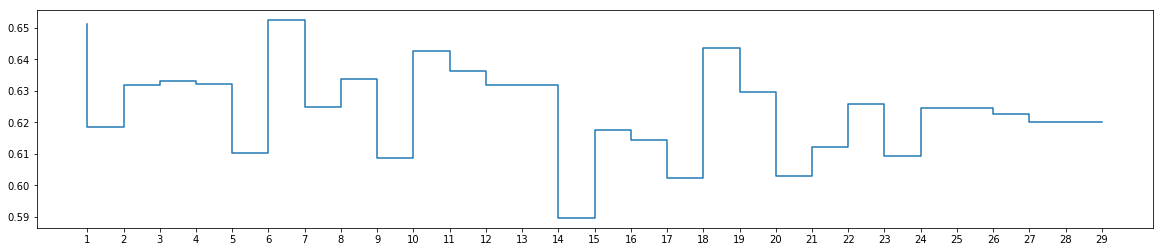

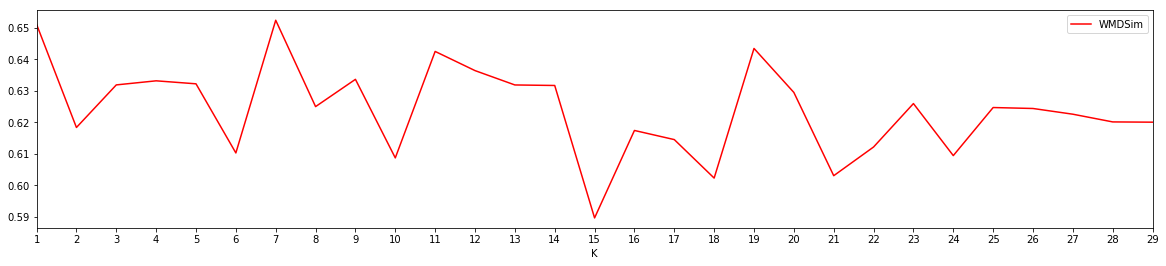

In [21]:
rows = [
    [1, 0.651111],
    [2, 0.618366],
    [3,	0.631886],
    [4,	0.633181],
    [5,	0.632232],
    [6,	0.610281],
    [7,	0.652414],
    [8,	0.624995],
    [9,	0.633652],
    [10,0.608711],
    [11,0.642512],
    [12,0.636427],
    [13,0.631869],
    [14,0.631704],
    [15,0.589656],
    [16,0.617420],
    [17,0.614523],
    [18,0.602303],
    [19,0.643463],
    [20,0.629490],
    [21,0.603060],
    [22,0.612172],
    [23,0.625960],
    [24,0.609440],
    [25,0.624700],
    [26,0.624398],
    [27,0.622582],
    [28,0.620135],
    [29,0.620052]
]

metrics = KMetrics(rows)
metrics.show()

In [ ]:
inspector_k1 = create_inspector(k=1, verbose=True)
inspector_k7 = create_inspector(k=7, verbose=True)

In [ ]:
sample = random_sample()

inspector_k1.inspect(sample)
inspector_k7.inspect(sample)